Preamble

In [1]:
import numpy as np
from tqdm.notebook import tqdm_notebook
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
images_resized = np.load('images_resized.npy')
depths_resized = np.load('depths_resized.npy')

In [118]:
# Normalize input
X = images_resized.reshape(images_resized.shape[0], -1)
y_mean = depths_resized.reshape(depths_resized.shape[0], -1).mean(axis=1)

x_use, x_test, y_use, y_test = train_test_split(
    X, y_mean, test_size=0.2, shuffle=True
)

x_use = np.load('x_use.npy', allow_pickle=True)
x_test = np.load('x_test.npy', allow_pickle=True)
y_use = np.load('y_use.npy', allow_pickle=True)
y_test = np.load('y_test.npy', allow_pickle=True)


In [4]:
np.save('x_use.npy', x_use)
np.save('x_test.npy', x_test)
np.save('y_use.npy', y_use)
np.save('y_test.npy', y_test)

Linear Polynomial Regression (i.e. degree = 1)

In [81]:
# Polynomial features
poly = PolynomialFeatures(degree=1)
scaler = StandardScaler()

batch_size = 64

regularization_params = np.logspace(-10, 10, 20)

iterations = 10

In [ ]:
rmse_training_lin = []

for _ in tqdm_notebook(range(iterations), desc="Iterations"):
    rmse_iter = []

    x_train, x_valid, y_train, y_valid = train_test_split(
            x_use, y_use, test_size=0.2, shuffle=True)
    
    n_batches = len(x_train) // batch_size

    for param in regularization_params:
        # Process in batches
        model = SGDRegressor(
            max_iter=1000, 
            learning_rate='adaptive', 
            eta0=0.001, 
            alpha=param, 
            random_state=42
        )


        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = start_idx + batch_size
            
            x_batch = x_train[start_idx:end_idx]
            y_batch = y_train[start_idx:end_idx]
            
            # Debug: check batch size
            if len(x_batch) == 0:
                print(f"Empty batch at iteration {i}, skipping")
                continue
            
            x_batch_poly = poly.fit_transform(x_batch) if i == 0 else poly.transform(x_batch)
            x_batch_scaled = scaler.fit_transform(x_batch_poly) if i == 0 else scaler.transform(x_batch_poly)
            
            model.partial_fit(x_batch_scaled, y_batch)

        # Evaluate on valid (in batches too)
        valid_predictions = []
        for i in range(0, len(x_valid), batch_size):
            x_valid_batch = x_valid[i:i+batch_size]
            x_valid_poly = poly.transform(x_valid_batch)
            x_valid_scaled = scaler.transform(x_valid_poly)
            valid_predictions.extend(model.predict(x_valid_scaled))

        y_pred = np.array(valid_predictions)
        y_pred = np.maximum(y_pred, 0)  # Clip negative values to 0
        rmse_iter.append(np.sqrt(mean_squared_error(y_valid, y_pred)))
    rmse_training_lin.append(rmse_iter)

rmse_training_lin = np.array(rmse_training_lin)

In [ ]:
rmse_training_lin = rmse_training_lin.reshape(10, len(regularization_params))
np.save('rmse_training_linear.npy', rmse_training_lin) # (N, C, H, W)

<>:17: SyntaxWarning: invalid escape sequence '\l'
<>:17: SyntaxWarning: invalid escape sequence '\l'
/var/folders/vk/j2m7k9sj5mxc_jzrmzsgtlgm0000gn/T/ipykernel_29170/1260697627.py:17: SyntaxWarning: invalid escape sequence '\l'
  ax1.set_xlabel("Regularization, $\lambda$")


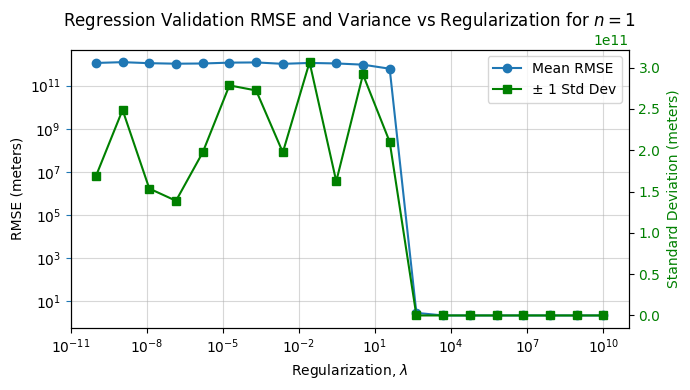

In [88]:
# rmse_training_lin = np.load('rmse_training_linear.npy', allow_pickle=True)


mean = []
ci_low = []
ci_high = []

fig, ax1 = plt.subplots(figsize=(7, 4))

mean_rmse = rmse_training_lin.mean(axis=0)
std_rmse = rmse_training_lin.std(axis=0)

# print(mean_rmse > 400)

# Primary axis - RMSE
line1 = ax1.plot(regularization_params, mean_rmse, marker='o', label='Mean RMSE')
ax1.set_xlabel("Regularization, $\lambda$")
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel("RMSE (meters)")
ax1.minorticks_on()
ax1.grid(True, which='major', alpha=0.5)
ax1.grid(True, which='minor', alpha=0.3, linestyle=':')
ax1.tick_params(axis='y', color='C0')

# Secondary axis - Std Dev
ax2 = ax1.twinx()
line2 = ax2.plot(regularization_params, std_rmse, marker='s', color='green', label='± 1 Std Dev')
ax2.set_ylabel("Standard Deviation (meters)", color='green')
# ax2.set_ylim([-1e-5, 1e-4])  # Set your own limits here
# ax2.set_yscale('log')  # Or 'linear'
ax2.tick_params(axis='y', labelcolor='green')

plt.title("Regression Validation RMSE and Variance vs Regularization for $n=1$")
lines = line1+line2
plt.legend(line1+line2, [l.get_label() for l in lines], loc='best')
fig.tight_layout()
plt.show()
pass

# print((mean_rmse[-1]))
      
# print(std_rmse[-1])

<>:17: SyntaxWarning: invalid escape sequence '\l'
<>:17: SyntaxWarning: invalid escape sequence '\l'
/var/folders/vk/j2m7k9sj5mxc_jzrmzsgtlgm0000gn/T/ipykernel_29170/1591288629.py:17: SyntaxWarning: invalid escape sequence '\l'
  ax1.set_xlabel("Regularization, $\lambda$")


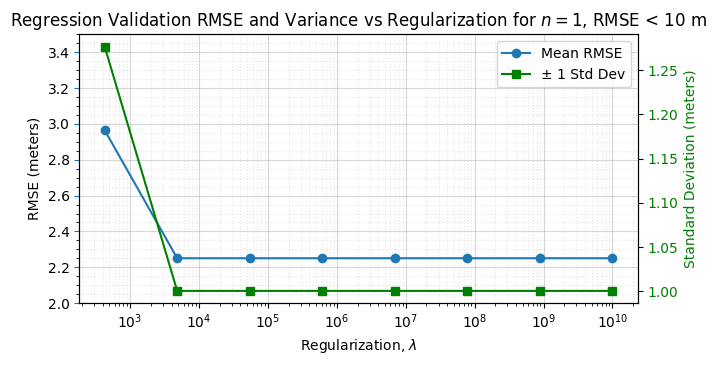

In [ ]:
# rmse_training_lin = np.load('rmse_training_linear.npy', allow_pickle=True)

mean = []
ci_low = []
ci_high = []

fig, ax1 = plt.subplots(figsize=(7, 3.75))

mean_rmse = rmse_training_lin.mean(axis=0)
std_rmse = rmse_training_lin.std(axis=0)

# print(mean_rmse > 400)

# Primary axis - RMSE
line1 = ax1.plot(regularization_params[mean_rmse < 400], mean_rmse[mean_rmse < 400], marker='o', label='Mean RMSE')
ax1.set_xlabel("Regularization, $\lambda$")
ax1.set_xscale('log')
# ax1.set_yscale('log')
ax1.set_ylabel("RMSE (meters)")
ax1.set_ylim([2, 3.5])  # Set your own limits here

ax1.minorticks_on()
ax1.grid(True, which='major', alpha=0.5)
ax1.grid(True, which='minor', alpha=0.3, linestyle=':')
ax1.tick_params(axis='y', color='C0')


# Secondary axis - Std Dev
ax2 = ax1.twinx()
line2 = ax2.plot(regularization_params[mean_rmse < 400], std_rmse[mean_rmse < 400], marker='s', color='green', label='± 1 Std Dev')
ax2.set_ylabel("Standard Deviation (meters)", color='green')
# ax2.set_ylim([-1e-5, 1e-4])  # Set your own limits here
# ax2.set_yscale('log')  # Or 'linear'
ax2.tick_params(axis='y', labelcolor='green')

plt.title("Regression Validation RMSE and Variance vs Regularization for $n=1$, RMSE < 10 m")
lines = line1+line2
plt.legend(line1+line2, [l.get_label() for l in lines], loc='best')
fig.tight_layout()
plt.show()
pass

# print((mean_rmse[-1]))
      
# print(std_rmse[-1])

In [151]:
# Evaluate on test (in batches too)

min_lambda = regularization_params[np.argmin(mean_rmse)]

print(f"Minimum lamba from validation data: {min_lambda}")

n_test_batches = len(x_train) // batch_size

x_train, x_valid, y_train, y_valid = train_test_split(
            x_use, y_use, test_size=0.2, shuffle=True)

model = SGDRegressor(
            max_iter=1000, 
            learning_rate='adaptive', 
            eta0=0.001, 
            alpha=min_lambda, 
            random_state=42
        )

for i in range(n_test_batches):
    start_idx = i * batch_size
    end_idx = start_idx + batch_size
    
    x_batch = x_train[start_idx:end_idx]
    y_batch = y_train[start_idx:end_idx]
    
    # Debug: check batch size
    if len(x_batch) == 0:
        print(f"Empty batch at iteration {i}, skipping")
        continue
    
    x_batch_poly = poly.fit_transform(x_batch) if i == 0 else poly.transform(x_batch)
    x_batch_scaled = scaler.fit_transform(x_batch_poly) if i == 0 else scaler.transform(x_batch_poly)
    
    model.partial_fit(x_batch_scaled, y_batch)

test_predictions = []
for i in range(0, len(x_valid), batch_size):
    x_test_batch = x_valid[i:i+batch_size]
    x_test_poly = poly.transform(x_test_batch)
    x_test_scaled = scaler.transform(x_test_poly)
    test_predictions.extend(model.predict(x_test_scaled))

y_hat = np.array(test_predictions)
y_hat = np.maximum(y_hat, 0)  # Clip negative values to 0
rmse_test = np.sqrt(mean_squared_error(y_valid, y_hat))
print(f"RMSE: {rmse_test}")

Minimum lamba from validation data: 4832.930238571752
RMSE: 2.1155294735809185


In [ ]:
# Percentage of predictions that are exactly 0
zero_predictions = (y_hat == 0).sum() / len(y_hat) * 100
print(f"{zero_predictions:.1f}% of predictions are 0.0")

# Percentage where error > 1 meter
large_errors = (np.abs(y_test - y_hat) > 1.0).sum() / len(y_hat) * 100
print(f"{large_errors:.1f}% of predictions have error > 1 meter")

# Max error
max_error = np.abs(y_test - y_hat).max()
print(f"Worst prediction off by: {max_error:.2f} meters")

# Show distribution
errors = y_test - y_hat
print(f"Error range: [{errors.min():.2f}, {errors.max():.2f}]")

10.0% of predictions are 0.0
87.9% of predictions have error > 1 meter
Worst prediction off by: 6.74 meters
Error range: [-1.24, 6.74]


Quadratic Polynomial Regression (i.e. degree = 2)

In [ ]:
# Normalize input
X = images_resized.reshape(images_resized.shape[0], -1)
y_mean = depths_resized.reshape(depths_resized.shape[0], -1).mean(axis=1)

x_use, x_test, y_use, y_test = train_test_split(
    X, y_mean, test_size=0.2, shuffle=True
)

# Polynomial features
poly = PolynomialFeatures(degree=2)
scaler = StandardScaler()

batch_size = 64

regularization_params = np.exp(np.linspace(-10, 10, 20))

iterations = 10

In [ ]:
rmse_training_quad = []

for _ in tqdm_notebook(range(iterations), desc="Iterations"):

    x_train, x_valid, y_train, y_valid = train_test_split(
            x_use, y_use, test_size=0.2, random_state=42)
    
    n_batches = len(x_train) // batch_size

    for param in regularization_params:
        # Process in batches
        model = SGDRegressor(
            max_iter=1000, 
            learning_rate='adaptive', 
            eta0=0.001, 
            alpha=param, 
            random_state=42
        )


        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = start_idx + batch_size
            
            x_batch = x_train[start_idx:end_idx]
            y_batch = y_train[start_idx:end_idx]
            
            # Debug: check batch size
            if len(x_batch) == 0:
                print(f"Empty batch at iteration {i}, skipping")
                continue
            
            x_batch_poly = poly.fit_transform(x_batch) if i == 0 else poly.transform(x_batch)
            x_batch_scaled = scaler.fit_transform(x_batch_poly) if i == 0 else scaler.transform(x_batch_poly)
            
            model.partial_fit(x_batch_scaled, y_batch)

        # Evaluate on valid (in batches too)
        valid_predictions = []
        for i in range(0, len(x_valid), batch_size):
            x_valid_batch = x_valid[i:i+batch_size]
            x_valid_poly = poly.transform(x_valid_batch)
            x_valid_scaled = scaler.transform(x_valid_poly)
            valid_predictions.extend(model.predict(x_valid_scaled))

        y_pred = np.array(valid_predictions)
        y_pred = np.maximum(y_pred, 0)  # Clip negative values to 0
        rmse_training_quad.append(np.sqrt(mean_squared_error(y_valid, y_pred)))

rmse_training_quad = np.array(rmse_training_quad) / iterations

Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
rmse_training_quad = rmse_training_quad.reshape(10, len(regularization_params))
np.save('rmse_training_quad.npy', rmse_training_quad) # (N, C, H, W)

<>:15: SyntaxWarning: invalid escape sequence '\l'
<>:15: SyntaxWarning: invalid escape sequence '\l'
/var/folders/vk/j2m7k9sj5mxc_jzrmzsgtlgm0000gn/T/ipykernel_16784/2078179136.py:15: SyntaxWarning: invalid escape sequence '\l'
  ax1.set_xlabel("Regularization, $\lambda$")


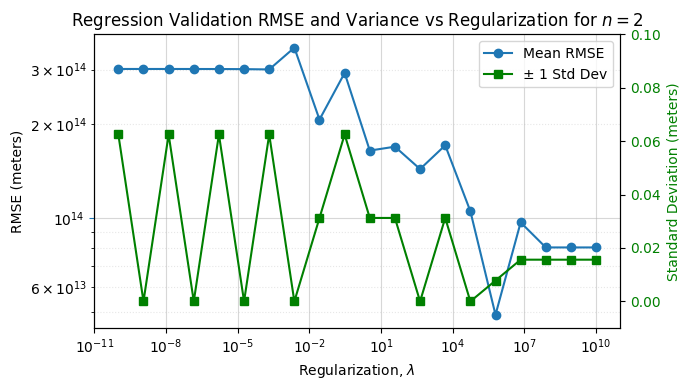

In [ ]:
rmse_training_quad = np.load('rmse_training_quad.npy', allow_pickle=True)


mean = []
ci_low = []
ci_high = []

fig, ax1 = plt.subplots(figsize=(7, 4))

mean_rmse = rmse_training_quad.mean(axis=0)
std_rmse = rmse_training_quad.std(axis=0)

# Primary axis - RMSE
line1 = ax1.plot(regularization_params, mean_rmse, marker='o', label='Mean RMSE')
ax1.set_xlabel("Regularization, $\lambda$")
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel("RMSE (meters)")
ax1.minorticks_on()
ax1.grid(True, which='major', alpha=0.5)
ax1.grid(True, which='minor', alpha=0.3, linestyle=':')
ax1.tick_params(axis='y', color='C0')

# Secondary axis - Std Dev
ax2 = ax1.twinx()
line2 = ax2.plot(regularization_params, std_rmse, marker='s', color='green', label='± 1 Std Dev')
ax2.set_ylabel("Standard Deviation (meters)", color='green')
ax2.set_ylim([-1e-2, 1e-1])  # Set your own limits here
# ax2.set_yscale('log')  # Or 'linear'
ax2.tick_params(axis='y', labelcolor='green')

plt.title("Regression Validation RMSE and Variance vs Regularization for $n=2$")
lines = line1+line2
plt.legend(line1+line2, [l.get_label() for l in lines], loc='best')
fig.tight_layout()
plt.show()
pass

In [ ]:
# Evaluate on test (in batches too)
 
min_lambda = regularization_params[np.argmin(rmse_training_quad)]

print(f"Minimum lamba from validation data: {min_lambda}")

n_test_batches = len(x_test) // batch_size


model = SGDRegressor(
            max_iter=1000, 
            learning_rate='adaptive', 
            eta0=0.001, 
            alpha=min_lambda, 
            random_state=42
        )

for i in range(n_test_batches):
    start_idx = i * batch_size
    end_idx = start_idx + batch_size
    
    x_batch = x_test[start_idx:end_idx]
    y_batch = y_test[start_idx:end_idx]
    
    # Debug: check batch size
    if len(x_batch) == 0:
        print(f"Empty batch at iteration {i}, skipping")
        continue
    
    x_batch_poly = poly.fit_transform(x_batch) if i == 0 else poly.transform(x_batch)
    x_batch_scaled = scaler.fit_transform(x_batch_poly) if i == 0 else scaler.transform(x_batch_poly)
    
    model.partial_fit(x_batch_scaled, y_batch)

test_predictions = []
for i in range(0, len(x_test), batch_size):
    x_test_batch = x_test[i:i+batch_size]
    x_test_poly = poly.transform(x_test_batch)
    x_test_scaled = scaler.transform(x_test_poly)
    test_predictions.extend(model.predict(x_test_scaled))

y_hat = np.array(test_predictions)
y_hat = np.maximum(y_hat, 0)  # Clip negative values to 0
rmse_test = np.sqrt(mean_squared_error(y_test, y_hat))
print(rmse_test)

Minimum lamba from validation data: 326.8409575425958
801263068373127.2


In [ ]:
# Percentage of predictions that are exactly 0
zero_predictions = (y_hat == 0).sum() / len(y_hat) * 100
print(f"{zero_predictions:.1f}% of predictions are 0.0")

# Percentage where error > 1 meter
large_errors = (np.abs(y_test - y_hat) > 1.0).sum() / len(y_hat) * 100
print(f"{large_errors:.1f}% of predictions have error > 1 meter")

# Max error
max_error = np.abs(y_test - y_hat).max()
print(f"Worst prediction off by: {max_error:.2f} meters")

# Show distribution
errors = y_test - y_hat
print(f"Error range: [{errors.min():.2f}, {errors.max():.2f}]")

48.3% of predictions are 0.0
100.0% of predictions have error > 1 meter
Worst prediction off by: 2742811183019447.50 meters
Error range: [-2742811183019447.50, 5.14]
